## Welcome to our Kick-Ass Demo

### Basic Implementation

In [1]:
# Lets import what we need:

import numpy as np
import autograd  as ad
import autograd.variable as av 
%matplotlib inline

Example 1: `f(x) = sin(x) + cos(x)` for x = 0

Define the mode you want to use : forward or reverse (default forward)

In [2]:
# Let's try forward...
ad.set_mode('forward')

In [3]:
# Set the x variable
x = av.Variable(0)

In [5]:
# Perform first operation
# Pass the value through the sin block
b1 = ad.sin(x)

In [6]:
# Perform the second operation
b2 = ad.cos(x)

In [7]:
# Perform the final operation 
b3 = b1 + b2

In [8]:
# Return data 
print(b3.data)

[1.]


The function we consider takes 1 input and returns 1 output : the jacobian matrix (described as gradient in the project) will be a matrix of shape 1x1.

Before trying to return a gradient, you need to call .compute_gradients()

Even though the gradients are computed on the fly in the forward mode, this function is required. It is used in the case where the function has several inputs, or during the reverse mode


In [9]:
b3.compute_gradients()

array([[1.]])

In [11]:
# Return gradient 
print(b3.gradient)


[[1.]]


### Reverse Mode

The case of reverse mode is exactly similar, you just need to specify the mode at the beginning of the computation, before defining any variables

In [4]:
# Let's try reverse...
ad.set_mode('reverse')

x = av.Variable(0)
b1 = ad.sin(x)
b2 = ad.cos(x)
b3 = b1 + b2

# Return data 
print('data : ',b3.data)

# Important step, this is where the gradients are propagated backwards
b3.compute_gradients()

# Return gradient 
print('gradient : ', b3.gradient)


data :  [1.]
gradient :  [[1.]]


If you want to use the reverse mode several times (for the optimizer for instance, you need to clear the computational graph everytime you want to do a new run of the function : 

In [13]:
ad.reset_graph()
b3.compute_gradients()

# Return gradient 
print('gradient : ', b3.gradient)

gradient :  [[1.]]


If you don't do this, the gradients will accumulate in the graph, giving absurd results: 

In [15]:
b3.compute_gradients()
# Return gradient 
print('gradient : ', b3.gradient)

b3.compute_gradients()
# Return gradient 
print('gradient : ', b3.gradient)

gradient :  [[6.]]
gradient :  [[10.]]


### Optimization

Now let's create a function to compute the derivative across a range of values:

In [6]:
# Return to forward mode
ad.set_mode('forward')

In [7]:
def function(x):
    x1 = av.Variable(x)
    b1 = ad.sin(x1)
    b2 = ad.cos(x1)
    b3 = b1 + b2
    b3.compute_gradients()
    return(b3.data,b3.gradient)

In [8]:
value = list()
data = list()
gradient = list()
for i in np.linspace(-2 * np.pi, 2 * np.pi):
    value.append(i)
    output = function(i)
    data.append(output[0])
    gradient.append(output[1][0])

Let's plot the values:

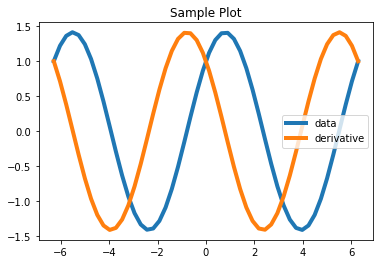

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('lines', linewidth=4, color='g')
plt.plot(value,data,label='data')
plt.plot(value,gradient,label='derivative')
plt.title("Sample Plot")
plt.legend()
plt.show()

Example 2: Create a function to evaluate at multiple values
`f(x) = sin(x + 3)*cos(x/2) + e^-x`

In [23]:
def function(x):
    x1=av.Variable(x)
    # Elementary operations such as + - / * 
    # Can be performed within other blocks
    b1 = ad.sin(x1 + 3)
    b2 = x1 / 2
    b3 = ad.cos(b2)
    b4 = b1/b3
    b5 = ad.exp(-x1) 
    b7 = b4 + b5
    b7.compute_gradients()
    return(b7.data,b7.gradient)

In [9]:
value = list()
data = list()
gradient = list()
for i in np.linspace(-2 * np.pi, 2 * np.pi):
    value.append(i)
    output = function(i)
    data.append(output[0][0])
    gradient.append(output[1][0])

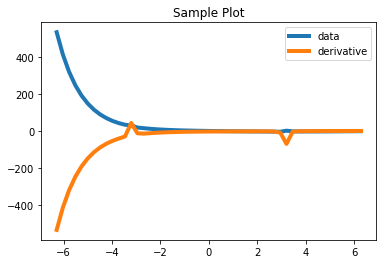

In [25]:
plt.plot(value,data,label='data')
plt.plot(value,gradient,label='derivative')
plt.title("Sample Plot")
plt.legend()
plt.show()

Let's look at the ca ase of multiple inputs:

You need to specify that you are working with multiple inputs : when you define your input variables, you will use the special (class) method 
```
x,y=Variable.multi_variables(data_for_x, data_for_y)
```

Example 3, using the vector framework with symetric role of x and y : 

`f(x,y)=cos(0.5*(x+y)) * exp(-0.1*(x**2 + y**2))+0.1*(x+y) + exp(0.1*(3-(x+y))`


In [11]:
def vector_function(x,y):
    x,y=av.Variable.multi_variables(x,y)
    
    
    b1 = ad.exp(-0.1*((x**2)+(y**2)))
    b2 = ad.cos(0.5*(x+y))
    b3 = b1*b2+0.1*(x+y)+ad.exp(0.1*(3-(x+y)))
    
    
    b3.compute_gradients()
    return(b3.data,b3.gradient)



In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        

   

In [14]:
x,y=0.1,-0.1

data, gradient = vector_function(x,y)

In case of multiple inputs, the .gradient() method returns the gradients of the output node with respect to each of the inputs : 

in our case, we defined z=f(x,y) we will have :
\begin{equation*}
z.gradients = [\frac{\partial z}{\partial x}, \frac{\partial z}{\partial y}]
\end{equation*}

In [33]:
gradient

[array([[-0.05494592]]), array([[-0.01502584]])]

In [34]:
def plot_nice_surface_and_gradients(f, lim_inf, lim_sup, iterations=50, startingPoint=(0.1,-0.1)):
    x=np.linspace(lim_inf,lim_sup,100)
    y=np.linspace(lim_inf,lim_sup,100)

    X,Y=np.meshgrid(x,y)
        
    def data_function(a,b):
        data, grad= f(a,b)
        return(data)
    
    vf=np.vectorize(data_function)

    Z=vf(X,Y)

    fig = plt.figure(figsize=(12,10))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                          cmap=cm.RdBu,linewidth=0, antialiased=False)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('vector function plus gradient descent algorithm')
    plt.legend()

    fig.colorbar(surf, shrink=0.5, aspect=5)


    x=startingPoint[0]
    y=startingPoint[1]

    lr=0.5

    for i in range(iterations):
        data, gradient = f(x,y)
        
        gradient_x=gradient[0]
        gradient_y=gradient[1]

        x_n=x-lr*gradient_x[0][0]
        y_n=y-lr*gradient_y[0][0]

        data_n, gradient_n=f(x_n, y_n)

        a = Arrow3D([x,x_n], [y,y_n], 
                [data[0],data_n[0]], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="r")
        ax.add_artist(a)

        x=x_n
        y=y_n
    ax.add_artist(a)
    plt.draw()
    plt.show()

Now if we want to perform Gradient Descent using our optimizer we can:

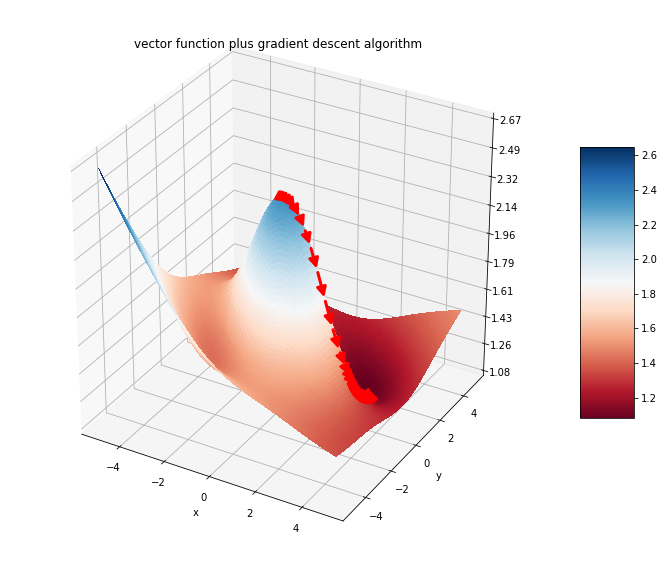

In [35]:
# Plotting a nice surface and gradient descent

plot_nice_surface_and_gradients(vector_function, -5,5)

Example 3, using the vector framework with non-symetric role of x and y : 

`f(x,y)=cos(x)*sin(y)`


In [38]:
def non_symetric(a,b):
    x,y=av.Variable.multi_variables(a,b)
    
    
    output=ad.cos(x)*ad.sin(y)
    
    output.compute_gradients()
    return(output.data, output.gradient)

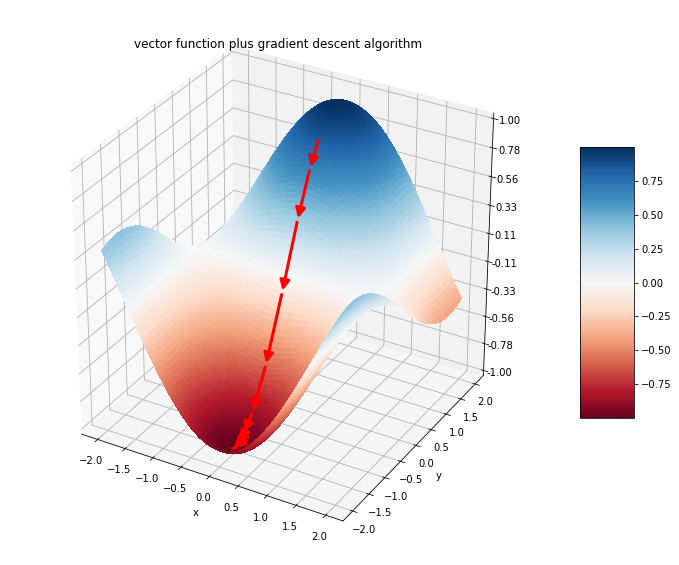

In [39]:
plot_nice_surface_and_gradients(non_symetric, -2,2, startingPoint=(0,1))

## Thank you very much!!